# Mounting Google Drive

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [24]:
!pip install pyflux
!pip install pmdarima

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pyflux as pf

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Variables Declaration

In [25]:
# references to the past data file
filePath = '/content/drive/My Drive/Wisata.csv'
white = 'white'
title_ACF = 'Autocorrelation Function Plot (ACF)'
title_PACF = 'Partial Autocorrelation Function (PACF)'

# Read and Load Time-Series Data

In [26]:
# read and load past data
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
data_all = pd.read_csv(filePath, index_col='time', parse_dates=True)

data = data_all[:-19]
data

,bps,trends
time,,
2010-01,6678,17
2010-02,6990,26
2010-03,7285,12
2010-04,6984,36
2010-05,8358,23
2010-06,7868,21
2010-07,8531,25
2010-08,7408,8
2010-09,5410,9


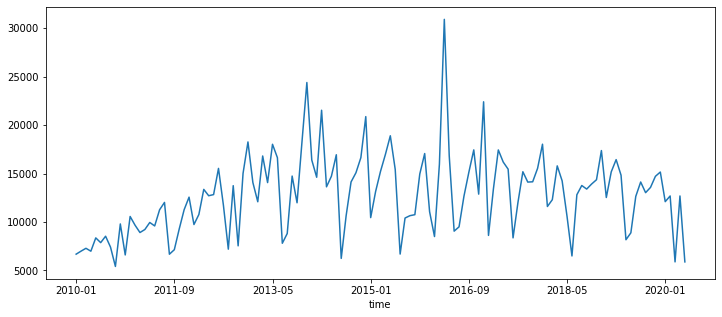

In [27]:
#Plot Data
data['bps'].plot(figsize=(12,5))

# Checking for Stationarity of Time-Series Data

In [28]:
# using The Augmented Dickey Fuller (ADF) test
def ad_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print('ADF = ',dftest[0])
  print('P-Value = ',dftest[1])
  print('Num of Lags = ',dftest[2])
  print('Num of Observations Used for ADF Regression and Critical Value Calculation = ',dftest[3])
  print('Critical Values : ')
  for key, val in dftest[4].items():
    print("\t",key,": ",val)

In [29]:
print('ADF Statistic for BPS: ')
ad_test(data['bps'])

ADF Statistic for BPS: 
ADF =  -2.3822708107499846
P-Value =  0.146802990789629
Num of Lags =  13
Num of Observations Used for ADF Regression and Critical Value Calculation =  111
Critical Values : 
	 1% :  -3.490683082754047
	 5% :  -2.8879516565798817
	 10% :  -2.5808574442009578


In [30]:
data['const']=1 #Adding a constant
data['diffS']=data['bps'].diff() #First order differencing for BPS
data['diffM']=data['trends'].diff() #First order differencing for Google Trends

#Fitting the model on the differenced data
model1=sm.OLS(endog=data['diffS'].dropna(),exog=data[['diffM','const']].dropna())
results1=model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  diffS   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.2899
Date:                Tue, 09 Feb 2021   Prob (F-statistic):              0.591
Time:                        04:19:39   Log-Likelihood:                -1220.8
No. Observations:                 124   AIC:                             2446.
Df Residuals:                     122   BIC:                             2451.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
diffM         22.6392     42.046      0.538      0.5

# Autocorrelation Function Plot (ACF) and Partial Autocorrelation Function (PACF)

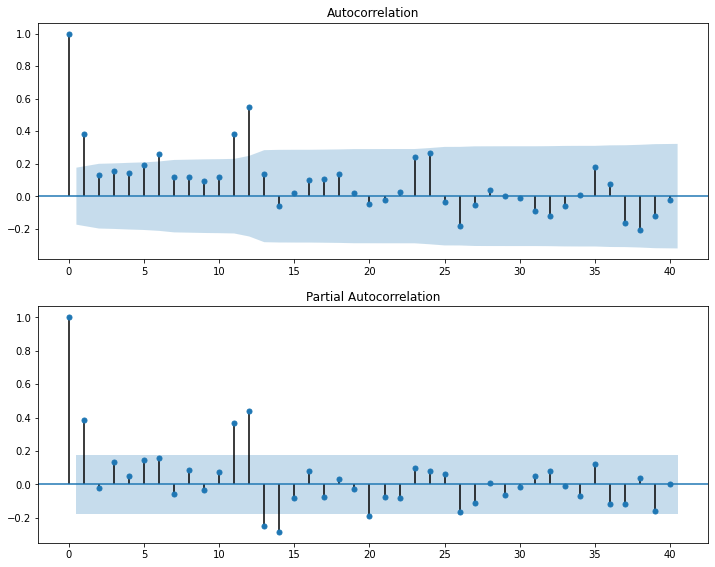

In [31]:
fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(411)
fig = sm.graphics.tsa.plot_acf(data['bps'], lags=40, ax=ax1)
ax2 = fig.add_subplot(412)
fig = sm.graphics.tsa.plot_pacf(data['bps'], lags=40, ax=ax2)
plt.show()

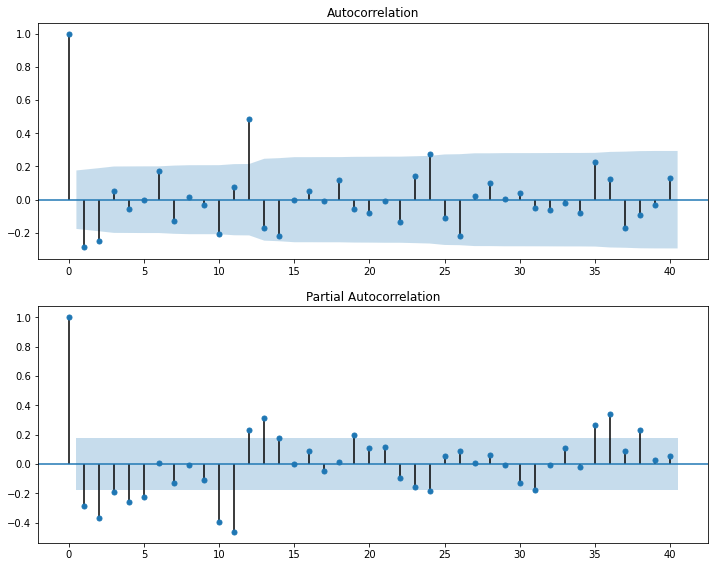

In [32]:
fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(411)
#Plots with first order differenced bps variable
fig = sm.graphics.tsa.plot_acf(data['bps'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(412)
fig = sm.graphics.tsa.plot_pacf(data['bps'].diff().dropna(), lags=40, ax=ax2)
plt.show()

# Figure Out Order of ARIMA Model

In [33]:
stepwise_fit = auto_arima(data['bps'], trace=True, suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2396.908, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2445.815, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2437.226, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2404.987, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2443.819, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2401.919, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2402.735, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2405.055, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2405.101, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2404.582, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2398.016, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2404.704, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2395.059, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

# Split Data into Training and Testing

In [34]:
print(data.shape)

train_data = data.iloc[:-100]
test_data = data.iloc[-30:]
print(train_data.shape, test_data.shape)

(125, 5)
(25, 5) (30, 5)


# Train Model ARIMA

In [35]:
model=ARIMA(train_data['bps'],order=(2,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.bps   No. Observations:                   24
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -210.945
Method:                       css-mle   S.D. of innovations           1485.112
Date:                Tue, 09 Feb 2021   AIC                            433.890
Time:                        04:19:45   BIC                            440.958
Sample:                    02-01-2010   HQIC                           435.765
                         - 01-01-2012                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         154.6163     42.472      3.640      0.000      71.373     237.860
ar.L1.D.bps    -0.8225      0.389     -2.112      0.035      -1.586      -0.059
ar.L2.D.bps    -0.0058      0.218     -0.027      0.979      -0.432       0.421
ma.L1.D.bps    -0.1131      0.364     -0.311      0.756      -0.827       0.601
ma.L2.D.bps    -0.8869      0.360     -2.461      0.014      -1.593      -0.180
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2265           +0.0000j            1.2265            0.5000
AR.2         -140.5414           +0.0000j          140.5414            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.1276           +0.0000j            1.1276            0.5000
-----------------------------------------------------------------------------
"""

Make Prediction on Test Set

In [36]:
start = len(train_data)
end = len(train_data)+len(test_data)-1
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')
pred.index=data.index[start:end+1]
pred

time
2012-02     10618.125658
2012-03     11103.056349
2012-04     10981.788016
2012-05     11361.391708
2012-06     11332.565790
2012-07-    11636.750483
2012-08     11669.417259
2012-09-    11923.464305
2012-10-    11997.010468
2012-11     12217.726786
2012-12     12318.448929
2013-01     12517.007498
2013-02     12635.795809
2013-03     12819.624252
2013-04     12950.422671
2013-05     13124.458755
2013-06-    13263.241306
2013-07     13430.767583
2013-08     13574.857860
2013-09     13738.056519
2013-10     13885.675290
2013-11     14045.997016
2013-12     14195.961475
2014-01     14354.370660
2014-02     14505.894496
2014-03     14663.032254
2014-04     14815.592739
2014-05     14971.885272
2014-06     15125.134906
2014-07     15280.865546
Name: ARIMA Predictions, dtype: float64

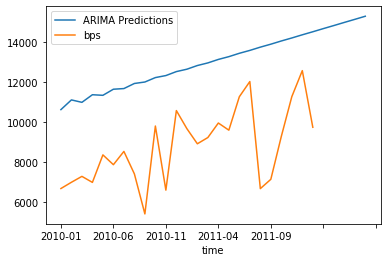

In [37]:
pred.plot(legend=True)
train_data['bps'].plot(legend=True)

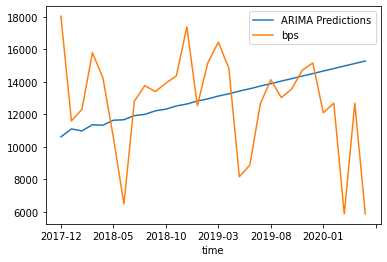

In [38]:
pred.plot(legend=True)
test_data['bps'].plot(legend=True)

In [39]:
mape = np.mean(np.abs((np.array(test_data['bps']) - pred) / np.array(test_data['bps']))) * 100
mse=mean_squared_error(pred,test_data['bps'])
rmse=np.sqrt(mean_squared_error(pred,test_data['bps']))

print('MAPE = {0:.4f} '.format(mape))
print('MSE = {0:.4f} '.format(mse))
print('RMSE = {0:.4f} '.format(rmse))

MAPE = 28.0312 
MSE = 13542905.9860 
RMSE = 3680.0687 


# Train the ARIMAX Model

In [40]:
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.
# using Best Model from ARIMA (2,1,2) => AR = 2; Diff/Integ = 1; MA = 2

arimax = pf.ARIMAX(data=data, formula='bps~trends',ar=2, integ=1, ma=2, family=pf.Normal())
model = arimax.fit("MLE")
model.summary()

Normal ARIMAX(2,1,2)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced bps                     Method: MLE                                       
Start Date: 2010-03                                     Log Likelihood: -1174.4346                        
End Date: 2020-05                                       AIC: 2362.8692                                    
Number of observations: 122                             BIC: 2382.4974                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    1.0522     0.1738     6.0547   0.0      (0.7116 | 1.3929)        
AR(2)                                

# Make Predictions on Test Data

In [41]:
pred_diff_data = arimax.predict(h=len(test_data), oos_data=test_data, intervals=False)

show_data = pred_diff_data.copy()
show_data['Predicted bps'] = test_data['bps'] + pred_diff_data['Differenced bps']

pred_data = test_data.copy()
pred_data['Predicted bps'] = show_data['Predicted bps']

# result of prediction
show_data['bps'] = test_data['bps']
show_data

,Differenced bps,Predicted bps,bps
time,,,
2017-12,5540.560988,23571.560988,18031
2018-01,1823.437914,13423.437914,11600
2018-02,-255.063923,12046.936077,12302
2018-03,-981.385049,14811.614951,15793
2018-04,-928.989831,13319.010169,14248
2018-05,-589.153469,9981.846531,10571
2018-06,-247.595661,6245.404339,6493
2018-07,-25.206717,12788.793283,12814
2018-08,73.793838,13839.793838,13766


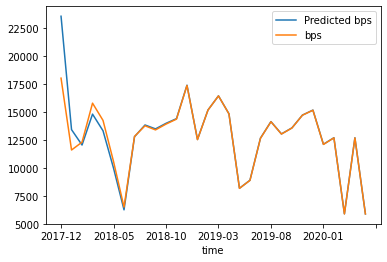

In [42]:
# plotting result of prediction
pred_data['Predicted bps'].plot(legend=True)
test_data['bps'].plot(legend=True)

# Evaluating ARIMAX Model

In [43]:
#Check error from model
MAPE = np.mean(np.abs((np.array(test_data['bps']) - pred_data['Predicted bps']) / np.array(test_data['bps']))) * 100
MSE = mean_squared_error(test_data['bps'],pred_data['Predicted bps'])
RMSE = np.sqrt(mean_squared_error(test_data['bps'],pred_data['Predicted bps']))

print('MAPE = {0:.4f} '.format(MAPE))
print('MSE = {0:.4f} '.format(MSE))
print('RMSE = {0:.4f} '.format(RMSE))

MAPE = 2.4804 
MSE = 1211522.5969 
RMSE = 1100.6919 


# Future Prediction using the ARIMAX Model

In [44]:
arimax_future = pf.ARIMAX(data=data_all, formula='bps~trends',ar=2, integ=1, ma=2, family=pf.Normal())
model_future = arimax_future.fit("MLE")
model_future.summary()

data_oos = pred_data[-19:]
future_diff_data = arimax_future.predict(h=19, oos_data=data_oos, intervals=False)
data_oos.index = future_diff_data.index 

# result of future prediction
show_data = future_diff_data.copy()
show_data['Future Predicted bps'] = data_oos['bps'] + future_diff_data['Differenced bps']
show_data

Normal ARIMAX(2,1,2)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced bps                     Method: MLE                                       
Start Date: 2010-03                                     Log Likelihood: -1358.6917                        
End Date: 2021-12                                       AIC: 2731.3834                                    
Number of observations: 141                             BIC: 2752.0247                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.1431    0.317      -0.4512  0.6518   (-0.7644 | 0.4783)       
AR(2)                                

,Differenced bps,Future Predicted bps
time,,
2020-06,-193.633867,14170.366133
2020-07,-214.821929,17160.178071
2020-08,-56.346175,12472.653825
2020-09,-53.386604,15118.613396
2020-10,-63.157708,16376.842292
2020-11,-72.251086,14757.748914
2020-12,-39.404924,8128.595076
2021-01,-193.744908,8687.255092
2021-02,-64.949344,12580.050656
